In [1]:
import pennylane as qml
import torch
from torch.autograd import Variable

In [7]:
import torch
from torch.autograd import Variable
import pennylane as qml

from pennylane import numpy as np

from random import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt

from tqdm import tqdm
%matplotlib inline

import scipy
from scipy import optimize

import time

In [60]:
shots = 100

class L2L(nn.Module):
    
    def __init__(self, functions):
        super().__init__()
        self.num_feats = 2  # rnn_output, qnn input params
        self.batch_size = 12
        self.rnn_input_size = 1 # qnn output size
        
        self.hid_cell = None
        self.rnn_output = None
        self.qnn_output = None
        
        self.lstm = nn.LSTM(
            input_size=self.rnn_input_size, hidden_size=self.num_feats, num_layers=1, dropout=0
        )
        
        self.functions = functions
        
        self.target = None

    def init_hid_cell(self, seq_len=1):
        self.rnn_output = torch.tensor([]) #torch.zeros(seq_len, self.batch_size, self.num_feats)
        self.qnn_output = torch.zeros(seq_len, self.batch_size, self.rnn_input_size)
        
        hidden = torch.zeros(seq_len, self.batch_size, self.num_feats)
        cell = torch.zeros(seq_len, self.batch_size, self.num_feats)
        self.hid_cell = (hidden, cell)

    def init_target(self):
        self.target = (torch.rand((self.batch_size, 6))-0.5)*2
        
    def cost(self, var, targets):
        expX = self.functions[0](var)
        expY = self.functions[1](var)

        return (targets[0] * expX[1] + targets[1] * expY[1] + targets[2]*expY[0] + targets[3]*expY[0] + targets[4]*expY[0] + targets[5]*expX[0]) ** 2

    def step(self):
        assert self.hid_cell is not None
    
        x = self.qnn_output[[-1], :, :]
        # display(f'RNN input {x.shape}')
        
        rnn_output, self.hid_cell = self.lstm(x, self.hid_cell)
        self.rnn_output = torch.cat((self.rnn_output, rnn_output), dim=0) #(seq_dim, batch_size, feature_size)
        # display(f'RNN output: {rnn_output.shape} RNN hist {self.rnn_output.shape}')
        
        assert rnn_output.shape[0] == 1
        qnn_output = torch.zeros_like(x)
        # this is gonna turn into proper batch handling
        for i in range(rnn_output.shape[1]):
            qnn_input_batch_element = rnn_output[0, i, :]
            qnn_output_batch_element = self.cost(qnn_input_batch_element, self.target[i])
            qnn_output[0, i, :] = qnn_output_batch_element # .view(1, 1, -1)

        qnn_output[0,:,:] = qnn_output[0,:,:]
        # display(f'circuit output: {qnn_output.shape}')
        self.qnn_output = torch.cat((self.qnn_output, qnn_output), dim=0)

        return self.qnn_output

    def loss(self, true):
        # display(f'true: {true.shape}, pred: {self.qnn_output.shape}')
        assert true.shape == self.qnn_output.shape
        
        return F.mse_loss(self.qnn_output, true)

    def numpy_output(self):
        return self.qnn_output.detach().numpy().squeeze()
    
dev = qml.device('default.qubit', wires=2)
# dev = qml.device('forest.qvm', device='Aspen-4-16Q-A', shots=shots)
# dev = qml.device('forest.qpu', device='Aspen-4-16Q-A', shots=shots) 
# dev_pyqvm = qml.device('forest.qvm', device='2q-pyqvm', shots=shots)

def ansatz(var):
    qml.Rot(0.3, 1.8, 5.4, wires=1)
    qml.RX(2*np.pi*var[0], wires=0)
    qml.RY(2*np.pi*var[1], wires=1)
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev, interface='torch')
def circuit_X(var):
    ansatz(var)
    return qml.expval(qml.PauliX(0)), qml.expval(qml.PauliX(1))

@qml.qnode(dev, interface='torch')
def circuit_Y(var):
    ansatz(var)
    return qml.expval(qml.PauliY(0)), qml.expval(qml.PauliY(1))

100%|██████████| 60/60 [02:37<00:00,  2.61s/it]

CPU times: user 3min 29s, sys: 1min 50s, total: 5min 19s
Wall time: 2min 37s


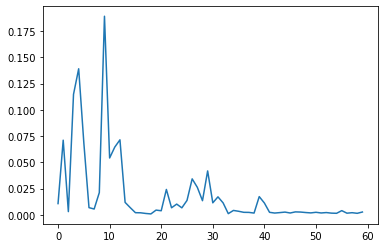

In [61]:
%%time 
l2l = L2L([circuit_X, circuit_Y])

optimizer = optim.Adam(l2l.parameters(), lr=0.1)

num_epoch = 60
num_steps = 10

all_loss = []
for epoch_ind in tqdm(range(num_epoch)):

    l2l.zero_grad()
    l2l.init_hid_cell()
    l2l.init_target()

    for i in range(num_steps):
        l2l.step()
#         print(l2l.qnn_output[])

    loss = l2l.loss(torch.zeros(num_steps + 1, l2l.batch_size, l2l.rnn_input_size))
    loss.backward()
    optimizer.step()

    all_loss.append(loss.item())

plt.plot(all_loss)

In [76]:
target = [0.75, -0.75, 0.5, 0.5, 0.33, 0.98]
num_steps = 25

# # dev = qml.device('default.qubit', wires=2)
# # dev = qml.device('forest.qvm', device='Aspen-4-2Q-A', shots=shots)
# dev = qml.device('forest.qpu', device='Aspen-4-2Q-A', shots=shots)

# def ansatz(var):
#     qml.Rot(0.3, 1.8, 5.4, wires=1)
#     qml.RX(2*np.pi*var[0], wires=0)
#     qml.RY(2*np.pi*var[1], wires=1)
#     qml.CNOT(wires=[0, 1])

# @qml.qnode(dev, interface='torch')
# def circuit_X(var):
#     ansatz(var)
#     return qml.expval(qml.PauliX(0)), qml.expval(qml.PauliX(1))

# @qml.qnode(dev, interface='torch')
# def circuit_Y(var):
#     ansatz(var)
#     return qml.expval(qml.PauliY(0)), qml.expval(qml.PauliY(1))

# l2l.function = [circuit_X, circuit_Y]

# neural optimizer
def neural_optimizer(target):
    l2l.batch_size = 1

    l2l.init_hid_cell()
    l2l.target = torch.tensor([target])

    for i in range(num_steps):
        l2l.step()

    return l2l.qnn_output[1:].view(-1).detach().numpy()

# gradient descent
def gradient_descent(target, dev):

    var = Variable(torch.rand(2), requires_grad=True)

    opt = torch.optim.Adam([var], lr = 0.1)

    def closure():
        opt.zero_grad()
        loss = l2l.cost(var, target)
        loss.backward()
        return loss

    GD_output = []

    for i in range(num_steps):
        loss = opt.step(closure)
#         phi_final, theta_final = opt.param_groups[0]['params']
#         GD_output.append(circuit(phi_final, theta_final)-target)
        GD_output.append(loss)

    return GD_output

#
def neldermead(targets, dev):
   
    def cost(var):
        return l2l.cost(var, targets)
    
    var = Variable(torch.rand(2), requires_grad=True)
    
    history = []
    def callback(x):
        fobj = cost(x)
        history.append(fobj)
    
    initial_par = np.random.rand(2)
    opt_parameters = scipy.optimize.minimize(cost, initial_par, method='Nelder-Mead', callback=callback,
                                             options={'maxfev': num_steps, 'return_all': False})
    
    return opt_parameters, history
    
    

start 1
0.13390541076660156
start 2
0.5530776977539062
start 3
0.18743896484375


Text(0.5, 1.0, 'VQE (simulation)')

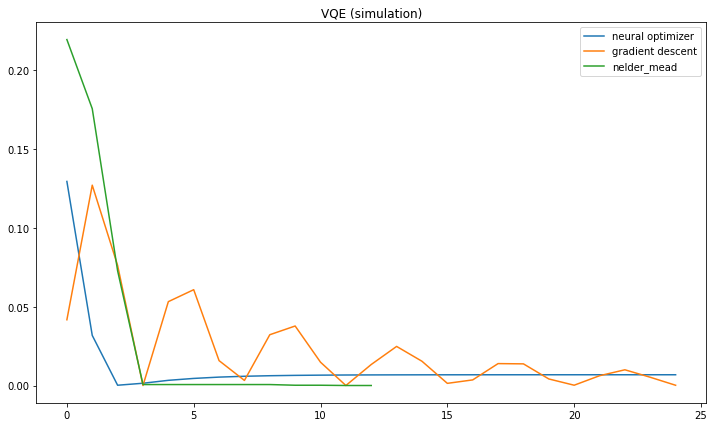

In [84]:
fig, ax = plt.subplots(figsize = (12,7))

dev = qml.device('default.qubit', wires=2) 

def ansatz(var):
    qml.Rot(0.3, 1.8, 5.4, wires=1)
    qml.RX(2*np.pi*var[0], wires=0)
    qml.RY(2*np.pi*var[1], wires=1)
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev, interface='torch')
def circuit_X(var):
    ansatz(var)
    return qml.expval(qml.PauliX(0)), qml.expval(qml.PauliX(1))

@qml.qnode(dev, interface='torch')
def circuit_Y(var):
    ansatz(var)
    return qml.expval(qml.PauliY(0)), qml.expval(qml.PauliY(1))

l2l.functions = [circuit_X, circuit_Y]

start = time.time()

print('start 1')
ax.plot(neural_optimizer(target))
stop = time.time()
print(stop-start)
print('start 2')
ax.plot(gradient_descent(target, dev))
print(time.time()-stop)
stop = time.time()
print('start 3')
opt_par, nelder_mead = neldermead(target, dev)
ax.plot(np.array(nelder_mead))
print(time.time()-stop)
ax.legend(['neural optimizer', 'gradient descent', 'nelder_mead'])
ax.set_title('VQE (simulation)')

start 1
5.283143997192383
start 2
26.514697551727295
start 3
7.250367164611816


Text(0.5, 1.0, 'VQE (Aspen-4-2Q-A)')

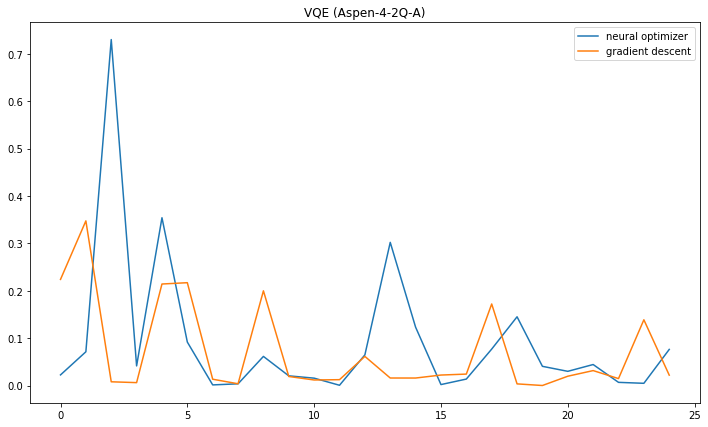

In [86]:
dev = qml.device('forest.qpu', device='Aspen-4-2Q-A', shots=shots) 

def ansatz(var):
    qml.Rot(0.3, 1.8, 5.4, wires=1)
    qml.RX(2*np.pi*var[0], wires=0)
    qml.RY(2*np.pi*var[1], wires=1)
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev, interface='torch')
def circuit_X(var):
    ansatz(var)
    return qml.expval(qml.PauliX(0)), qml.expval(qml.PauliX(1))

@qml.qnode(dev, interface='torch')
def circuit_Y(var):
    ansatz(var)
    return qml.expval(qml.PauliY(0)), qml.expval(qml.PauliY(1))

l2l.functions = [circuit_X, circuit_Y]

fig, ax = plt.subplots(figsize = (12,7))

start = time.time()

print('start 1')
ax.plot(neural_optimizer(target))
stop = time.time()
print(stop-start)
print('start 2')
ax.plot(gradient_descent(target, dev))
print(time.time()-stop)
stop = time.time()
print('start 3')
opt_par, nelder_mead = neldermead(target, dev)
# ax.plot(np.array(nelder_mead))
print(time.time()-stop)
ax.legend(['neural optimizer', 'gradient descent'])#, 'nelder_mead'])
ax.set_title('VQE (Aspen-4-2Q-A)')